In [2]:
import os, sys

os.chdir('Petreanu_MEI_generation')
sys.path.append(os.getcwd())

print(os.getcwd())

d:\Python\Anastasia\Petreanu Lab\Petreanu_MEI_generation


In [3]:
import torch 
import umap
import pandas as pd

In [4]:
meis_v1 = torch.load('runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor/meis_model_4.pth')
meis_pm = torch.load('runs/PM_MEI_in_vivo_validation_with_grid_mean_predictor/meis_model_2.pth')

meis = []
meis.extend(meis_v1)
meis.extend(meis_pm)

num_v1_meis = len(meis_v1)
num_pm_meis = len(meis_pm)

print(f'len meis, {len(meis)}')

len meis, 157


C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_53200\1476478939.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meis_v1 = torch.load('runs/V1_MEI_in_vivo_validatio

In [5]:
meis = [mei[0][0, :, :].detach().cpu().numpy() for mei in meis]

In [6]:
meis[0].shape

(68, 135)

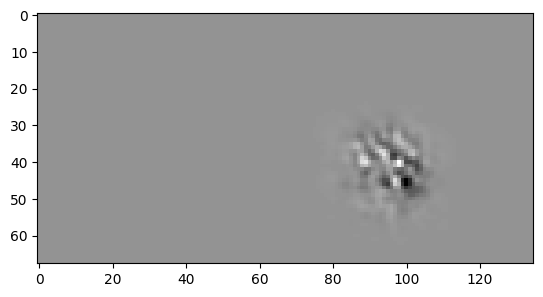

In [7]:
from matplotlib import pyplot as plt
plt.imshow(meis[0], cmap='gray')
plt.show()

In [78]:
epsilon=0.001
extracted_regions = []
images_to_remove = []

for i, img in enumerate(meis):
    # Mask for values that are not "close to zero" (i.e., values greater than epsilon in absolute value)
    mask = np.abs(img) > epsilon

    # Get the row and column indices of the non-zero values based on the mask
    rows, cols = np.nonzero(mask)

    # If no non-zero pixels are found (all values are considered zero), append None
    if len(rows) == 0 or len(cols) == 0:
        # extracted_regions.append(None)
        images_to_remove.append(i)
        continue

    # Get the bounding box (min/max row and column indices)
    min_row, max_row = min(rows), max(rows)
    min_col, max_col = min(cols), max(cols)

    # Extract the region within the bounding box
    region = img[min_row:max_row+1, min_col:max_col+1]

    # do not append region if it is larger than 60 x 60 = 3600 pixels
    if region.shape[0] * region.shape[1] > 3600:
        # extracted_regions.append(None)
        images_to_remove.append(i)
    else:
        extracted_regions.append(region)

print(f'Removed {len(images_to_remove)} images')
len(extracted_regions)

Removed 5 images


152

In [79]:
# For all extracted regions, prepend and append 0 values such that the shape is the same as for the largest

max_shape = max([region.shape for region in extracted_regions if region is not None])

for i, region in enumerate(extracted_regions):
    if region is None:
        continue

    # Get the shape of the region
    shape = region.shape

    # Calculate the number of rows and columns to prepend/append
    rows_to_prepend = (max_shape[0] - shape[0]) // 2
    rows_to_append = max_shape[0] - shape[0] - rows_to_prepend

    cols_to_prepend = (max_shape[1] - shape[1]) // 2
    cols_to_append = max_shape[1] - shape[1] - cols_to_prepend

    # Prepend and append rows and columns with zeros
    extracted_regions[i] = np.pad(region, ((rows_to_prepend, rows_to_append), (cols_to_prepend, cols_to_append)), mode='constant')

print(max_shape)

(41, 41)


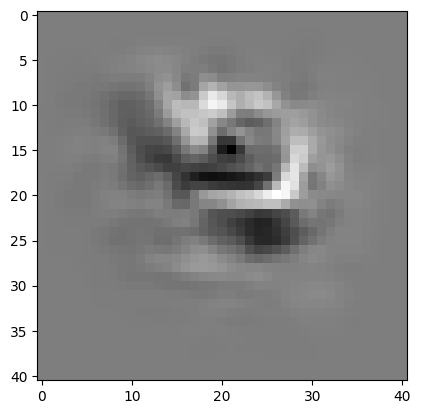

In [80]:
plt.imshow(extracted_regions[3], cmap='gray')
plt.show()

In [81]:
umapper = umap.UMAP()

In [82]:
# flattened_meis = [mei.flatten() for mei in meis]
flattened_meis = [mei.flatten() for mei in extracted_regions if mei is not None]

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
flattened_scaled_meis = scaler.fit_transform(flattened_meis)

In [84]:
embeddings = umapper.fit_transform(flattened_scaled_meis)

In [85]:
markers = ['o', 'x']

class_list = []
class_list.extend(['v1' for i in range(num_v1_meis)])
class_list.extend(['pm' for i in range(num_pm_meis)])
class_list = [0 if i == 'v1' else i for i in class_list]
class_list = [1 if i == 'pm' else i for i in class_list]

# remove indices of images that were removed

class_list = [class_list[i] for i in range(len(class_list)) if i not in images_to_remove]

C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_53200\3508165336.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='Spectral')


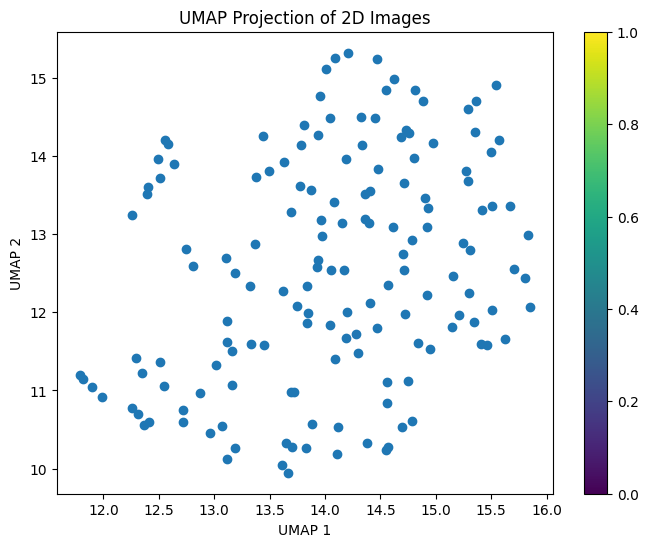

In [86]:
plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='Spectral')
plt.title('UMAP Projection of 2D Images')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.show()

C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_53200\2899108253.py:3: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(embeddings[i, 0], embeddings[i, 1],


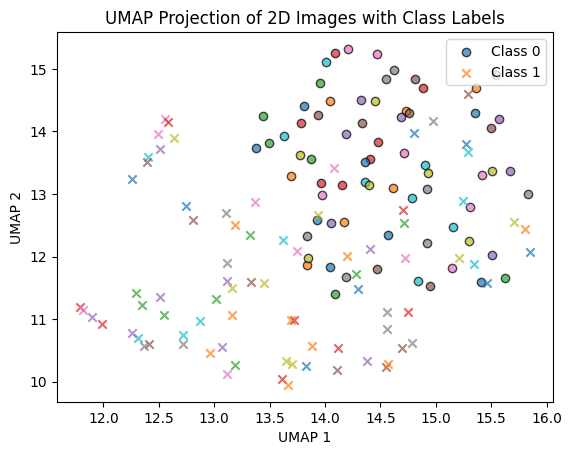

In [87]:
added_labels = []
for i, label in enumerate(class_list):
    plt.scatter(embeddings[i, 0], embeddings[i, 1], 
                marker=markers[label], label=f'Class {label}' if label not in added_labels else "", 
                alpha=0.7, edgecolors='k')
    added_labels.append(label)

plt.title('UMAP Projection of 2D Images with Class Labels')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Avoid duplicate legend entries
plt.legend(loc='upper right')

plt.show()

d:\anaconda3\envs\molanalysis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


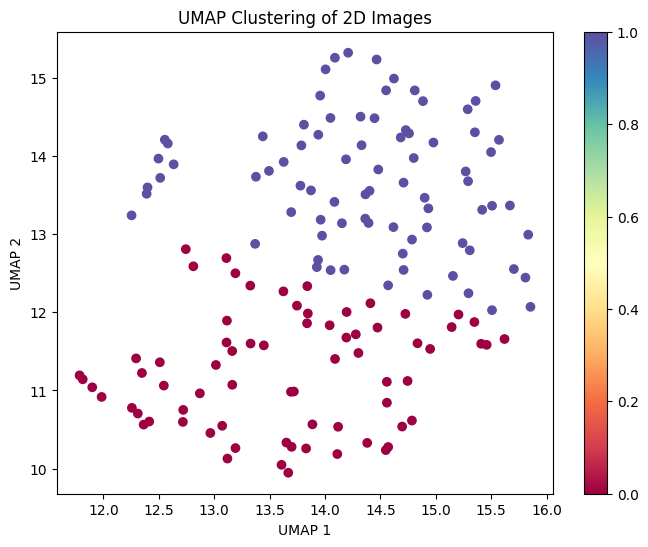

In [89]:
from sklearn.cluster import KMeans

# Fit KMeans on UMAP embeddings
kmeans = KMeans(n_clusters=2)  # Choose the number of clusters you want
kmeans.fit(embeddings)

# Get the cluster labels
labels = kmeans.labels_

# Plot the clusters with different colors
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='Spectral')
plt.title('UMAP Clustering of 2D Images')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(scatter)
plt.show()


C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_53200\2696164887.py:24: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(embeddings[i, 0], embeddings[i, 1],


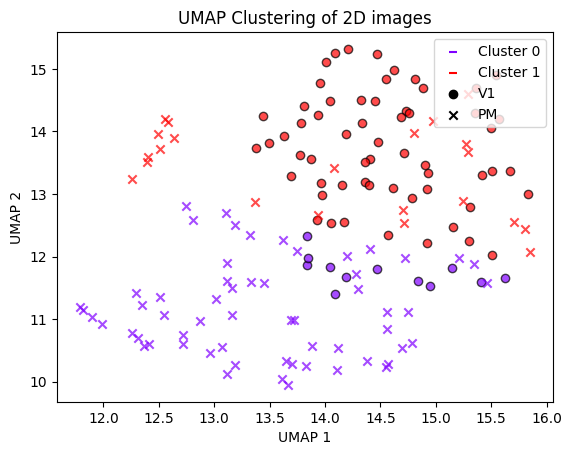

In [95]:
from sklearn.cluster import KMeans, DBSCAN
from matplotlib.pyplot import cm
import numpy as np

num_clusters = 2

# Fit KMeans on UMAP embeddings
# kmeans = KMeans(n_clusters=num_clusters)  # Choose the number of clusters you want
# kmeans.fit(embeddings)

# Get the cluster labels
labels = kmeans.labels_

dbscan = DBSCAN(eps=0.3, min_samples=4)
dbscan_labels = dbscan.fit_predict(embeddings)

# labels = dbscan_labels


color = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

added_labels = []
for i, label in enumerate(class_list):
    plt.scatter(embeddings[i, 0], embeddings[i, 1], 
                marker=markers[label], 
                alpha=0.7, edgecolors='k', color=color[labels[i]])
    added_labels.append(label)

legend_labels = ['V1', 'PM']
for i in range(num_clusters):
    plt.scatter([], [], color=color[i], label=f'Cluster {i}', marker='_')
for i in range(2):
    plt.scatter([], [], marker=markers[i], label=legend_labels[i], color='black')


plt.title('UMAP Clustering of 2D images')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Avoid duplicate legend entries
plt.legend(loc='upper right')

plt.show()

# Add in labeled and unlabeled cells

In [102]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
from sensorium.utility.training import read_config
from sensorium.utility import submission
from nnfabrik.builder import get_data, get_model
from sensorium.models.ensemble import EnsemblePrediction
from sensorium.utility import get_correlations
from sensorium.utility.measure_helpers import get_df_for_scores
from loaddata.session_info import load_sessions
from utils.plotting_style import *  # get all the fixed color schemes
from utils.imagelib import load_natural_images
from loaddata.get_data_folder import get_local_drive
from utils.pair_lib import compute_pairwise_anatomical_distance
from utils.rf_lib import *
import pickle as pkl

# Set working directory to root of repo
current_path = os.getcwd()
# Identify if path has 'molanalysis' as a folder in it
if 'Petreanu_MEI_generation' in current_path:
    # If so, set the path to the root of the repo
    current_path = current_path.split('Petreanu_MEI_generation')[0] + 'Petreanu_MEI_generation'
else:
    raise FileNotFoundError(
        f'This needs to be run somewhere from within the Petreanu_MEI_generation folder, not {current_path}')
os.chdir(current_path)
sys.path.append(current_path)

run_config = read_config('run_config.yaml') # Must be set
INPUT_FOLDER = run_config['data']['INPUT_FOLDER']
sessions_to_keep = [['LPE13959', '2025_02_24']]

try: 
    session_folders
except NameError:
    # First level
    session_folders = [os.path.join(INPUT_FOLDER, name) for name in os.listdir(
        INPUT_FOLDER) if os.path.isdir(os.path.join(INPUT_FOLDER, name)) and not "merged_data" in name]
    session_folders = [x.replace("\\", "/") for x in session_folders]
    # Second level
    files = [[session_folder, os.path.join(session_folder, name).replace('\\', '/')] for session_folder in session_folders for name in os.listdir(
        session_folder) if os.path.isdir(os.path.join(session_folder, name)) and not "merged_data" in name]
    # only get last value after /
    session_list = [[session_folder.split("/")[-1], name.split("/")[-1]]
                    for session_folder, name in files]

    # drop ['LPE10919', '2023_11_08'] because the data is not converted yet
    session_list = [x for x in session_list if x != ['LPE10919', '2023_11_08']]

if sessions_to_keep != 'all':
    session_list = [x for x in session_list if x in sessions_to_keep]

session_list = np.array(session_list)

print(session_list)

[['LPE13959' '2025_02_24']]


In [103]:
sessions, nSessions = load_sessions(protocol='IM', session_list=session_list, data_folder = INPUT_FOLDER)

for ises in range(nSessions):    # Load proper data and compute average trial responses:
    sessions[ises].load_respmat(calciumversion='deconv', keepraw=False)

sessions = compute_pairwise_anatomical_distance(sessions)
sessions = smooth_rf(sessions,radius=75,rf_type='Fneu')
sessions = exclude_outlier_rf(sessions) 
sessions = replace_smooth_with_Fsig(sessions) 

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing pairwise anatomical distance for each session: 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]
Setting outlier RFs to NaN: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [105]:
celldata = sessions[0].celldata
celldata

,iscell,iscell_prob,skew,radius,npix_soma,npix,xloc,...,recombinase,session_id,rf_az_Fsmooth,rf_el_Fsmooth,rf_sx_Fsmooth,rf_sy_Fsmooth,rf_r2_Fsmooth
0,1.0,0.917326,5.980925,8.389091,157.0,172.0,465.234375,...,non,LPE13959_2025_02_24,99.513110,31.205298,NaN,NaN,1.000000
1,1.0,0.988401,8.282103,7.690224,143.0,172.0,118.359375,...,non,LPE13959_2025_02_24,73.542776,28.001962,NaN,NaN,1.000000
2,1.0,0.996226,9.465027,5.839460,106.0,127.0,235.546875,...,non,LPE13959_2025_02_24,77.532161,30.886447,NaN,NaN,1.000000
3,1.0,0.971806,7.692322,6.673438,105.0,136.0,544.921875,...,cre,LPE13959_2025_02_24,91.780238,33.942454,38.915069,6.41469,0.231648
4,1.0,0.984217,6.789249,6.524613,122.0,145.0,385.546875,...,cre,LPE13959_2025_02_24,92.686224,31.389018,NaN,NaN,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3631,1.0,0.627150,1.241703,4.294106,65.0,77.0,452.343750,...,non,LPE13959_2025_02_24,NaN,NaN,NaN,NaN,NaN
3632,1.0,0.851016,0.618288,5.141607,80.0,132.0,441.796875,...,non,LPE13959_2025_02_24,NaN,NaN,NaN,NaN,NaN
3633,1.0,0.628065,1.073125,5.056850,56.0,68.0,450.000000,...,non,LPE13959_2025_02_24,NaN,NaN,NaN,NaN,NaN
3634,1.0,0.836071,0.616728,5.054649,76.0,106.0,360.937500,...,non,LPE13959_2025_02_24,NaN,NaN,NaN,NaN,NaN


In [106]:
celldata.columns

Index(['iscell', 'iscell_prob', 'skew', 'radius', 'npix_soma', 'npix', 'xloc', 'yloc', 'redcell', 'frac_of_ROI_red', 'frac_red_in_ROI', 'chan2_prob', 'nredcells', 'plane_idx', 'roi_idx', 'plane_in_roi_idx', 'roi_name', 'depth', 'power_mw', 'labeled', 'arealabel', 'rf_az_F', 'rf_el_F', 'rf_sx_F', 'rf_sy_F', 'rf_r2_F', 'rf_az_Fneu', 'rf_el_Fneu', 'rf_sx_Fneu', 'rf_sy_Fneu', 'rf_r2_Fneu', 'meanF', 'meanF_chan2', 'noise_level', 'event_rate', 'cell_id', 'layer', 'recombinase', 'session_id', 'rf_az_Fsmooth', 'rf_el_Fsmooth', 'rf_sx_Fsmooth', 'rf_sy_Fsmooth', 'rf_r2_Fsmooth'], dtype='object')

In [120]:
cell_ids_v1 = pd.read_csv('runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor/results/cell_ids.csv')
cell_ids_pm = pd.read_csv('runs/PM_MEI_in_vivo_validation_with_grid_mean_predictor/results/cell_ids.csv')

cell_ids_v1['index'] = cell_ids_v1.index
cell_ids_pm['index'] = cell_ids_pm.index

In [122]:
celldata_v1 = celldata.merge(cell_ids_v1, on='cell_id', how='right')
celldata_pm = celldata.merge(cell_ids_pm, on='cell_id', how='inner')
celldata_v1

,iscell,iscell_prob,skew,radius,npix_soma,npix,xloc,...,rf_az_Fsmooth,rf_el_Fsmooth,rf_sx_Fsmooth,rf_sy_Fsmooth,rf_r2_Fsmooth,neuron_idx,index
0,1.0,0.875082,1.676437,6.258075,135.0,142.0,555.468750,...,108.560806,27.083071,NaN,NaN,1.000000,2470,0
1,1.0,0.979491,9.651328,5.341870,85.0,95.0,145.312500,...,82.742968,27.213426,8.495735,5.310947,0.352140,538,1
2,1.0,0.941530,1.980759,5.141672,94.0,112.0,382.031250,...,103.346549,24.539192,9.308822,9.154505,0.523398,1835,2
3,1.0,0.980153,5.795259,4.566631,79.0,97.0,278.906250,...,89.876855,27.945499,NaN,NaN,1.000000,1198,3
4,1.0,0.995216,9.168126,5.186247,95.0,107.0,267.187500,...,90.465259,26.467005,NaN,NaN,1.000000,539,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1.0,0.567731,0.798199,5.224855,102.0,118.0,577.734375,...,111.222352,30.382628,12.187503,7.496195,0.386349,1630,70
71,1.0,0.965399,4.008502,4.916511,99.0,145.0,38.671875,...,71.174864,26.976253,NaN,NaN,1.000000,546,71
72,1.0,0.540202,2.363200,4.167052,62.0,81.0,189.843750,...,82.125358,26.471357,NaN,NaN,1.000000,1611,72
73,1.0,0.948876,3.081385,4.582008,78.0,181.0,362.109375,...,89.782762,20.070225,5.969652,7.876448,0.260089,126,73


In [129]:
celldata_full = pd.concat([celldata_v1, celldata_pm], ignore_index=True)
redcells = celldata_full['redcell'].values

# remove indices of images that were removed
redcells = [redcells[i] for i in range(len(redcells)) if i not in images_to_remove]

C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_53200\1827779142.py:5: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(embeddings[i, 0], embeddings[i, 1],


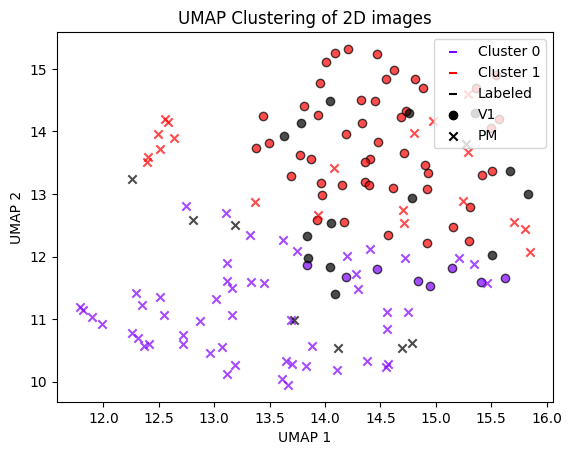

In [132]:
# Plot UMAP images with a separate color for labeled cells where redcell == 1

added_labels = []
for i, (label, redcell) in enumerate(zip(class_list, redcells)):
    plt.scatter(embeddings[i, 0], embeddings[i, 1], 
                marker=markers[label], 
                alpha=0.7, edgecolors='k', color=color[labels[i]] if redcell == 0 else 'black')
    added_labels.append(label)

legend_labels = ['V1', 'PM']
for i in range(num_clusters):
    plt.scatter([], [], color=color[i], label=f'Cluster {i}', marker='_')
plt.scatter([], [], color='black', label='Labeled', marker='_')
for i in range(2):
    plt.scatter([], [], marker=markers[i], label=legend_labels[i], color='black')


plt.title('UMAP Clustering of 2D images')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Avoid duplicate legend entries
plt.legend(loc='upper right')

plt.show()